In [196]:
from ariadne.util.deeppcb import DeepPCBData
from pathlib import Path
from PIL import Image, ImageDraw
import numpy as np
import torch
import torchvision
import skimage as ski
import collections
from enum import IntEnum

import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rc('image', cmap='gray')

%matplotlib inline

In [2]:
ds = DeepPCBData(Path('/Users/moon/git/DeepPCB'))

_, gr = ds.groups[0]

pair = gr[0]
annot = DeepPCBData._read_annot(pair['annotpath'])
img_test = np.asarray(Image.open(pair['testpath']).convert('1'))
img_truth = np.asarray(Image.open(pair['templatepath']).convert('1'))

In [7]:
def showdefects(img, defects):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(img)
    for defect in defects:
        rect = patches.Rectangle((defect.x0,defect.y0), defect.width, defect.height,
                                facecolor='none', edgecolor='r')
        ax.add_patch(rect)
        ax.text(defect.x0, defect.y0-5, f'{defect.ty.name}', color='r')
    
    return fig, ax

(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot: >)

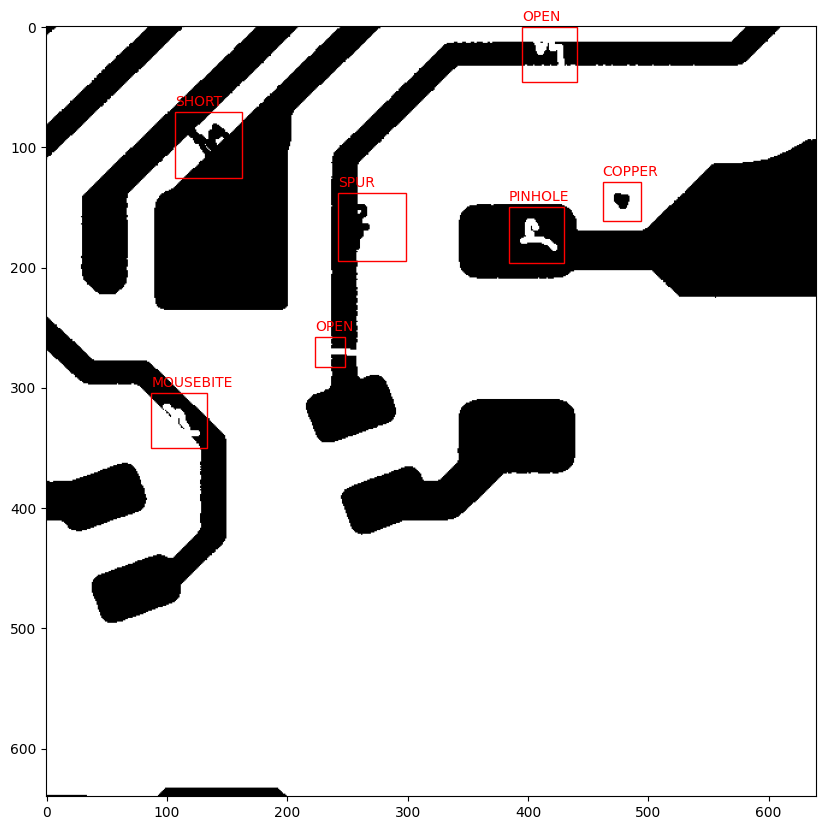

In [188]:
showdefects(img_test, annot)

(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot: >)

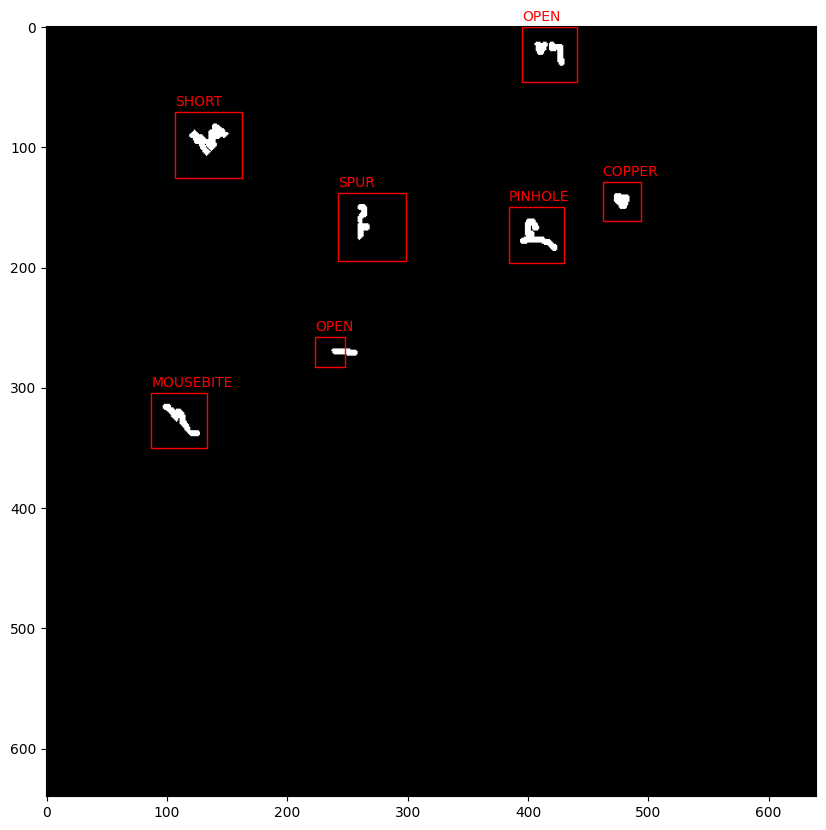

In [192]:
defect_mask = ski.morphology.binary_opening(img_test^img_truth)
showdefects(defect_mask, annot)

In [55]:
blobs = ski.morphology.binary_closing(defect_mask, ski.morphology.square(3))
labels = ski.measure.label(blobs)
# showdefects(ski.color.label2rgb(labels, bg_label=0), annot)

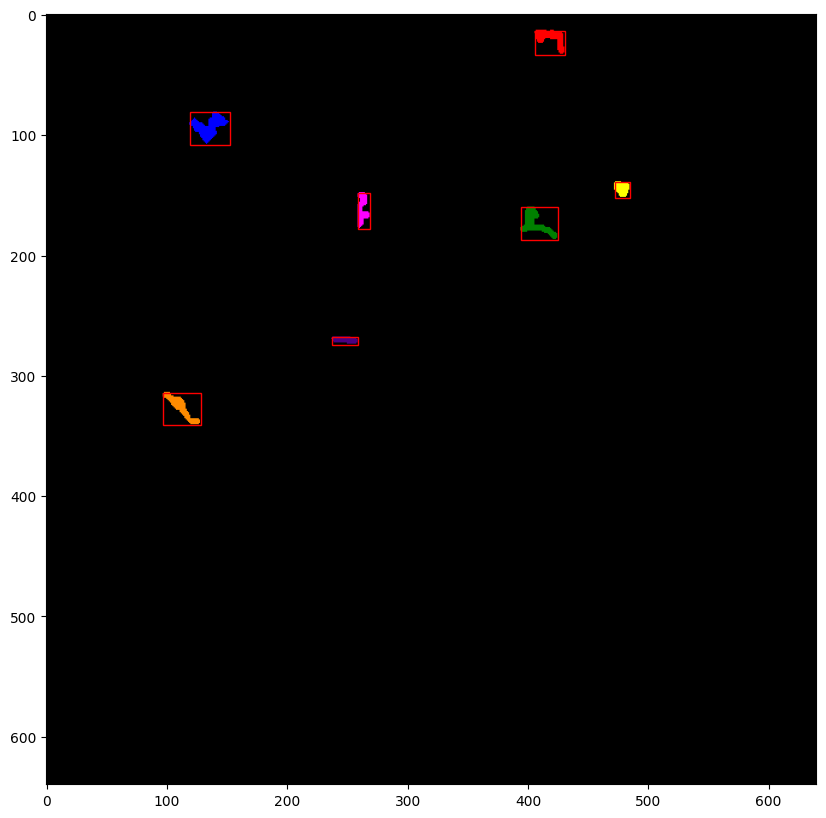

In [144]:
fig, ax = plt.subplots(figsize=(10,10))
img_labels = ski.color.label2rgb(labels, bg_label=0)
ax.imshow(img_labels)

for region in ski.measure.regionprops(labels):
    minr, minc, maxr, maxc = region.bbox
    rect = patches.Rectangle((minc, minr), maxc-minc, maxr-minr,
                            facecolor='none', edgecolor='r')
    ax.add_patch(rect)

In [76]:
region

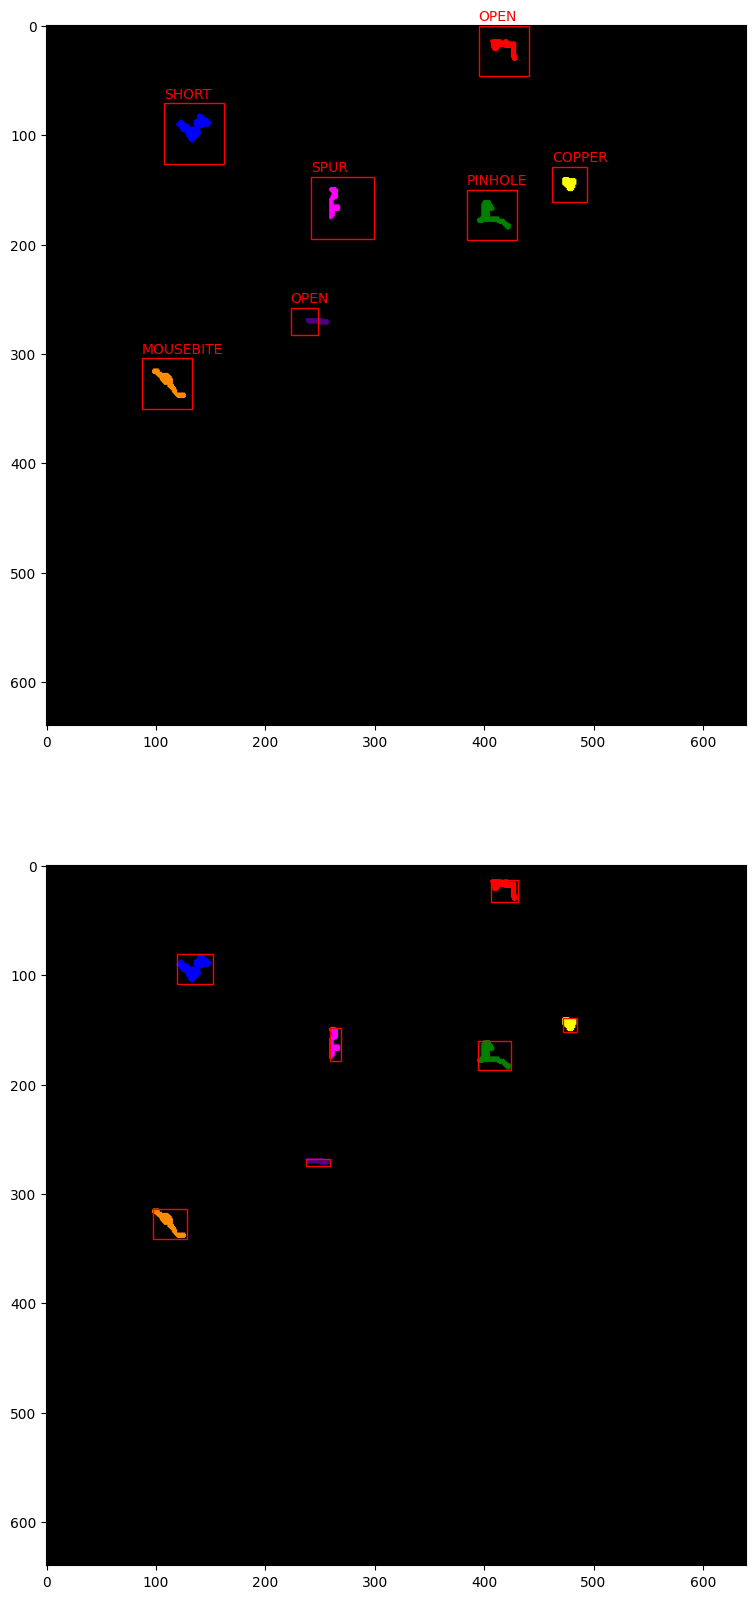

In [58]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,20))
ax1.imshow(ski.color.label2rgb(labels, bg_label=0))
for defect in annot:
    rect = patches.Rectangle((defect.x0,defect.y0), defect.width, defect.height,
                            facecolor='none', edgecolor='r')
    ax1.add_patch(rect)
    ax1.text(defect.x0, defect.y0-5, f'{defect.ty.name}', color='r')

ax2.imshow(ski.color.label2rgb(labels, bg_label=0))
for region in ski.measure.regionprops(labels):
    minr, minc, maxr, maxc = region.bbox
    rect = patches.Rectangle((minc, minr), maxc-minc, maxr-minr,
                            facecolor='none', edgecolor='r')
    ax2.add_patch(rect)


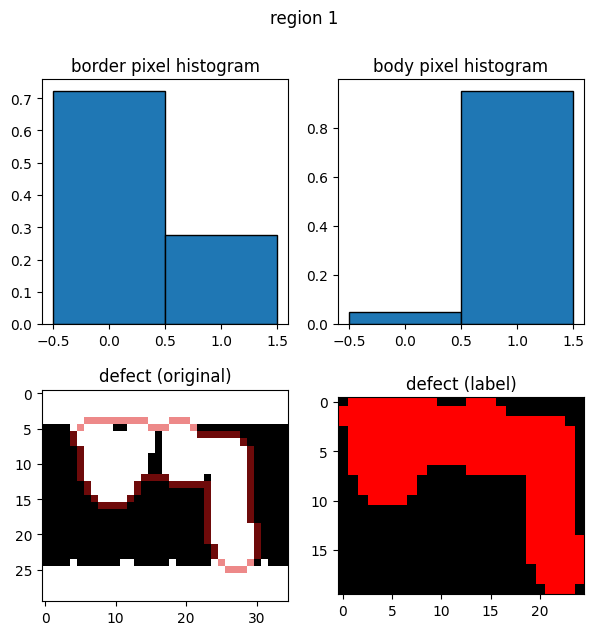

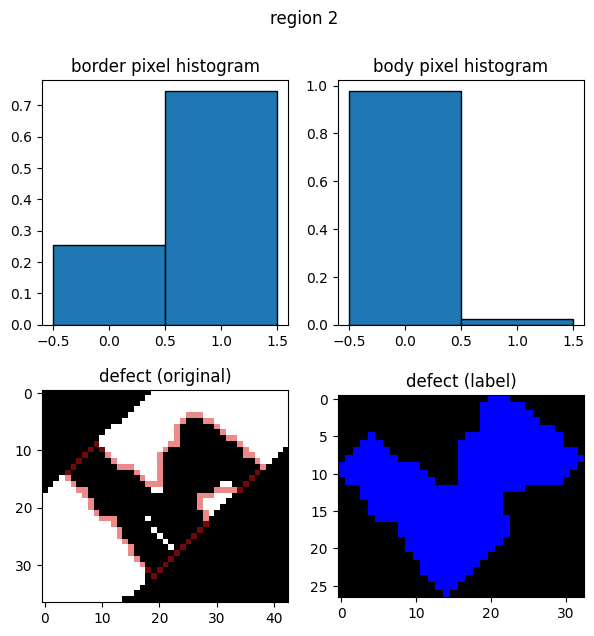

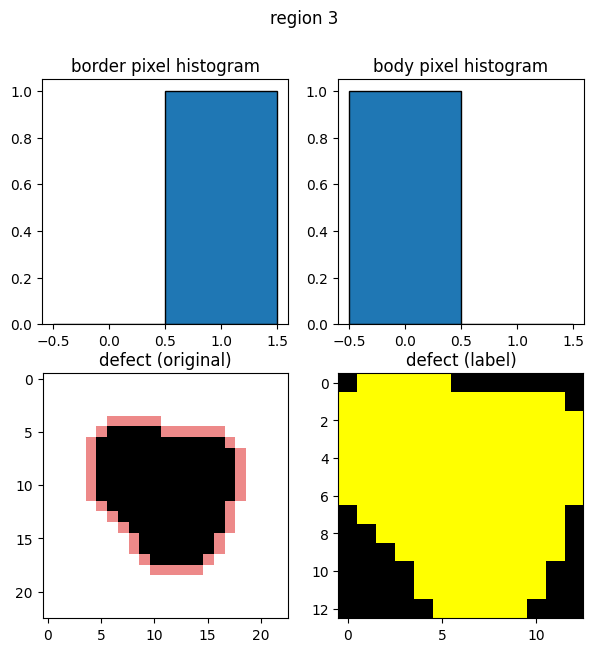

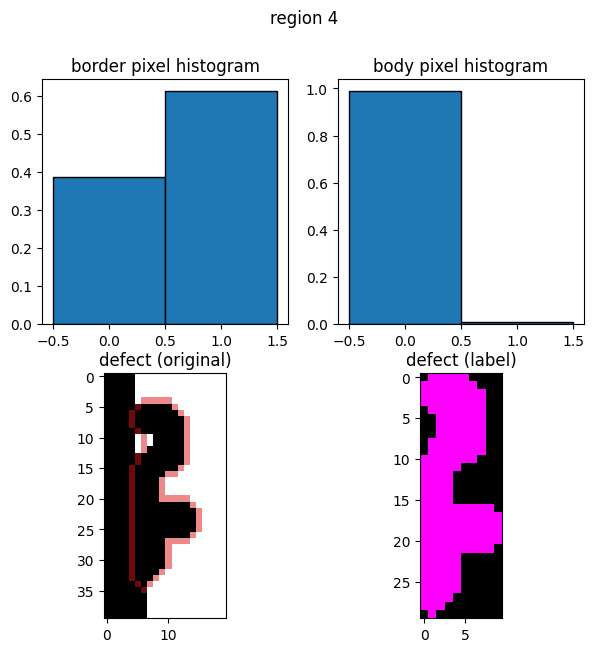

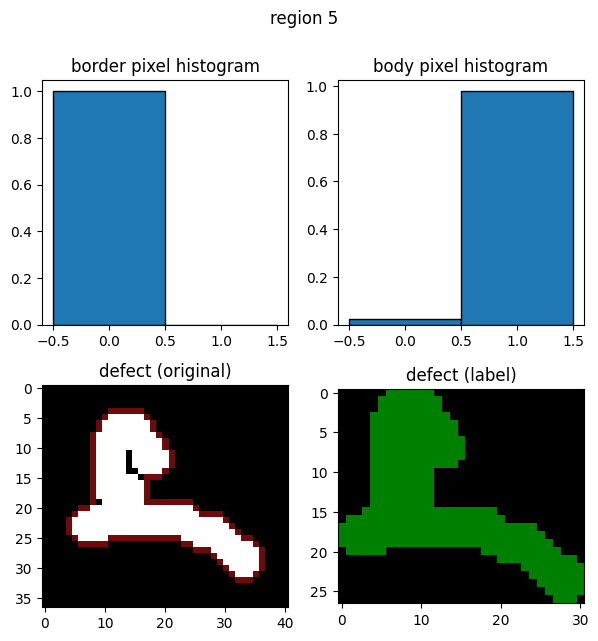

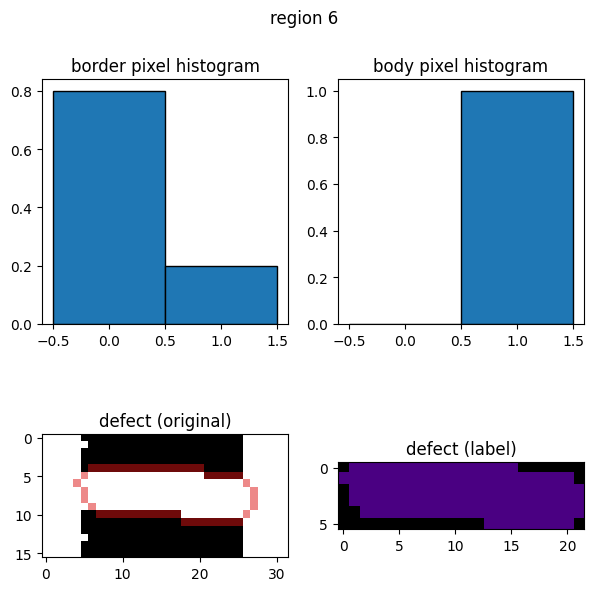

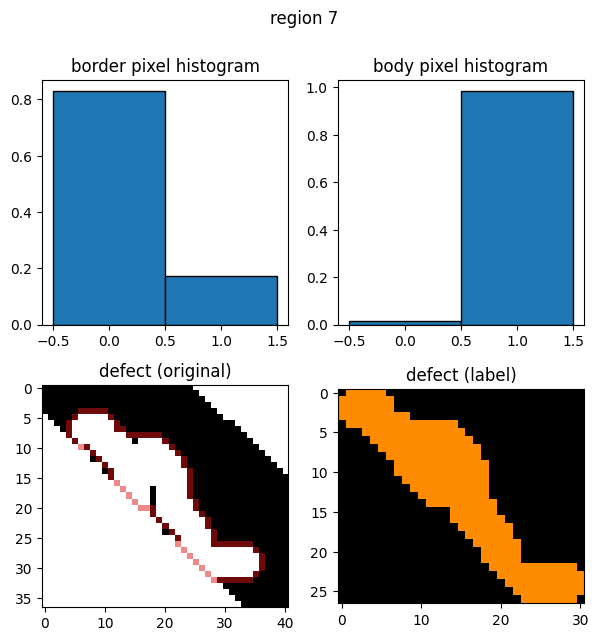

In [184]:
for region in ski.measure.regionprops(labels):
    contours = ski.measure.find_contours(labels == region.label, 0)
    assert(len(contours) == 1)
    contour = contours[0]

    rows, cols = contour.astype(np.int64).T
    fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(7,7))
    fig.suptitle(f'region {region.label}')
    ax11.set_title('border pixel histogram')
    ax11.hist(img_test[rows,cols]*1, bins=[-.5,.5,1.5], ec='k', density=True)
    ax12.set_title('body pixel histogram')
    ax12.hist(img_test[labels==region.label]*1, bins=[-.5,.5,1.5], ec='k', density=True)
    
    ax21.set_title('defect (original)')
    defect_draw = ski.color.gray2rgb(img_test.copy()*255)
    defect_draw[rows, cols] = 0.5 * defect_draw[rows, cols] + 0.5* np.array((220, 20, 20))
    minr, minc, maxr, maxc = region.bbox
    ax21.imshow(defect_draw[(minr-5):(maxr+5), (minc-5):(maxc+5)])
    ax22.set_title('defect (label)')
    ax22.imshow(img_labels[region.slice])
    

In [305]:
class DefectType(IntEnum):
    BACKGROUND = 0
    OPEN       = 1
    SHORT      = 2
    MOUSEBITE  = 3
    SPUR       = 4
    COPPER     = 5
    PINHOLE    = 6

# wf -> "white fraction"
def _wf(x):
    return np.count_nonzero(x)/x.size

def feature_extract(img_test, labels, region):
#     plt.imshow(labels == region.label)
    contours = ski.measure.find_contours(labels == region.label, 0)
#         plt.imshow(labels[region.slice])
    assert(len(contours) == 1)
    rows, cols = contours[0].astype(np.int64).T
    
    border_wf = _wf(img_test[rows, cols])
    body_wf = _wf(img_test[labels==region.label])

    return np.array([border_wf, body_wf])

def find_defects(img_ref, img_test):
    defect_mask = ski.morphology.binary_opening(img_ref^img_test)
    blobs = ski.morphology.binary_closing(defect_mask, ski.morphology.square(3))
#     plt.imshow(ski.morphology.remove_small_holes(blobs, 1))
    
    labels = ski.measure.label(blobs)
    
    for region in ski.measure.regionprops(labels):
        print(feature_extract(img_test, labels, region))


In [306]:
for _, gr in ds.groups[:1]:
    for pair in gr:
        annot = DeepPCBData._read_annot(pair['annotpath'])
        img_test = np.asarray(Image.open(pair['testpath']).convert('1'))
        img_ref = np.asarray(Image.open(pair['templatepath']).convert('1'))
        
        find_defects(img_ref, img_test)

[0.27710843 0.95      ]
[0.74444444 0.02406417]
[1. 0.]
[0.61333333 0.01075269]
[0.         0.97741935]
[0.2 1. ]
[0.17073171 0.98373984]
[0. 1.]


AssertionError: 

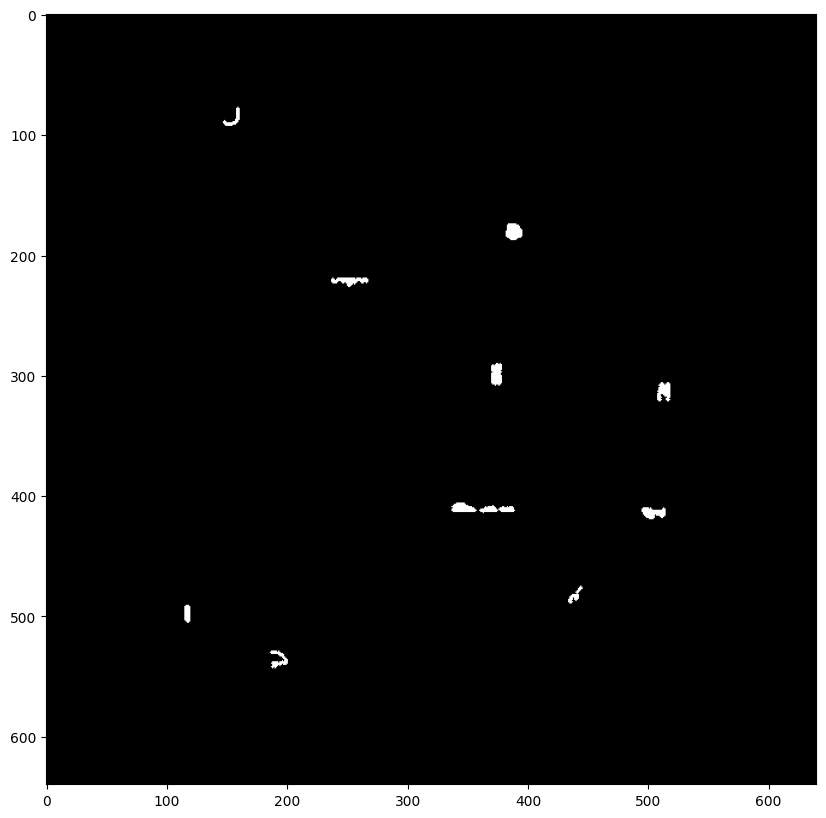

In [309]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(ski.morphology.remove_small_holes(defect_mask))